In [2]:
episodefile = open("../data/EpisodeList.txt","r")
episodeList = []

for line in episodefile:
    episodeList.append(line.strip().lower().replace(",",""))

SeasonList = [10,10,10,10,10,10,7,6]
episodeTuple = []
ekstranumb = 0
for numb in range(len(SeasonList)):
    for i in range(SeasonList[numb]):
        episodeTuple.append((numb+1, episodeList[i+ekstranumb]))
    ekstranumb += SeasonList[numb]

In [3]:
import lyricsgenius
genius = lyricsgenius.Genius("Apa5yYNZVRkIvn1izsQWN5l957pSR9jiG24s8ExAPKE9FHY9gdq4W8P7GPavWn1n")
artist = genius.search_artist("Game of Thrones")
artist.save_lyrics()

Searching for songs by Game of Thrones...

Song 1: "Winter is Coming"
Song 2: "Tyrion’s Courtroom Speech from The Laws of Gods and Men"
Song 3: "Kill the Boy"
Song 4: "Mother’s Mercy"
Song 5: "The Kingsroad"
Song 6: "The House of Black and White"
Song 7: "The Children"
Song 8: "Hardhome"
Song 9: "Liste des personnages"
Song 10: "The Wars to Come"
Song 11: "The Queen’s Justice"
Song 12: "Lord Snow"
Song 13: "High Sparrow"
Song 14: "The Dance of Dragons"
Song 15: "The Wolf and the Lion"
Song 16: "Cripples, Bastards and Broken Things"
Song 17: "The Winds of Winter"
Song 18: "Battle of the Bastards"
Song 19: "Book of the Stranger"
Song 20: "The Door"
Song 21: "The Red Woman"
Song 22: "You Win or You Die"
Song 23: "The North Remembers"
Song 24: "The Pointy End"
Song 25: "The Mountain and the Viper"
Song 26: "Unbowed, Unbent, Unbroken"
Song 27: "Oathbreaker"
Song 28: "The Gift"
Song 29: "Dragonstone"
Song 30: "A Golden Crown"
Song 31: "Fire and Blood"
Song 32: "The Rains of Castamere"
Song 3

In [3]:
import json
jFile = open("Lyrics_GameofThrones.json", "r")
j = json.load(jFile)

#Ignore this
#Dont even worry about it
#Just a simple Dict comprehension, no need to analyze it
LyricsListDict = {j["songs"][w]["title_with_featured"].lower().replace(",",""):j["songs"][w]["lyrics"].encode("UTF-8").decode("UTF-8") 
                    for w in range(len(j["songs"])) 
                    if j["songs"][w]["title_with_featured"].lower().replace(",","") in episodeList}



In [4]:
SeasonDict = dict()
#SeasonDict format
# {Title:{Season:SeasonNumber,Script:ScriptText}}
for season, title in episodeTuple:
    SeasonDict[title] = { "season": season,"script":LyricsListDict[title]}
print(SeasonDict['winter is coming'])

{'season': 1, 'script': '35 ContributorsWinter is Coming LyricsEPISODE 1 - WINTER IS COMING[First scene opens with three Rangers riding through a tunnel, leaving the Wall, and going into the woods. (Eerie music in background) One Ranger splits off and finds a campsite full of mutilated bodies, including a child hanging from a tree branch. A birds-eye view shows the bodies arranged in a shield-like pattern. The Ranger rides back to the other two.]\n\nWAYMAR ROYCE: What d’you expect? They’re savages. One lot steals a goat from another lot and before you know it, they’re ripping each other to pieces.\n\nWILL: I’ve never seen wildlings do a thing like this. I’ve never seen a thing like this, not ever in my life.\n\nWAYMAR ROYCE: How close did you get?\n\nWILL: Close as any man would.\n\nGARED: We should head back to the wall.\n\nROYCE: Do the dead frighten you?\n\nGARED: Our orders were to track the wildlings. We tracked them. They won’t trouble us no more.\n\nROYCE: You don’t think he’ll 

In [5]:

def sceneNameChecker(screenLine:str, i:int, lineSplit:str, sceneList:list):
   
    if lineSplit[0] == "CUT TO" or i == 0 or screenLine.upper().startswith("CUT TO") or screenLine.startswith('EXT') or screenLine.startswith('INT'):
        
        if lineSplit[0].upper() == "CUT TO":

            sceneName = lineSplit[1].strip()
        elif screenLine.startswith('EXT'):
            sceneName = screenLine.strip().split("EXT")[1].strip()
        elif screenLine.startswith('INT'):
            sceneName = screenLine.strip().split("INT")[1].strip()
        elif "------" in screenLine:
            #print(screenLine)
            sceneName = "Unnamed Scene"
        elif screenLine.upper().startswith("CUT TO"):
            sceneName = screenLine.split("CUT TO")

        elif i == 0:
            #print(line)
            if len(screenLine.strip()) > 0:
                sceneName = screenLine.strip()
            else:
                sceneName = "Opening Scene"
        

        #Giving the sceneName an extra number if the sceneName occurs multiple times
        if str(sceneName) in sceneList:
            try:
                sceneName = str(sceneName) + "_" + str(sceneList.count(sceneName))
                #print(sceneName)
            # if i == 0:
            #     print(sceneName)
            except TypeError as error:
                print(sceneName)
            
        sceneList.append(sceneName)
        return sceneName, sceneList
    return False


def createDataframefromDict(screenplayDict:dict):
 
    dfcolumns = ['Person','SeasonNr','EpisodeID','EpisodeTitle','Scene','ScreenLine']


    sceneList = []
    allLines = []
    episodeID = 0
    

    for title in screenplayDict:

        episodeTitle = title
        episodeID += 1
        seasonNr = screenplayDict[title]['season']
        

        sceneName = ""
        screenLines = screenplayDict[title]['script'].split("\n")[1:]
        #print(screenLines)
        if title == "the kingsroad":
            print(screenLines)

        for i in range(len(screenLines)):
            
            line = screenLines[i]

            lineSplit = line.strip().split(":")

            if len(lineSplit) > 0:

                if sceneNameChecker(line,i,lineSplit,sceneList) != False:
                    sceneName, sceneList = sceneNameChecker(line,i,lineSplit, sceneList)

                elif line.startswith('TITLE SEQUENCE') or line.startswith('CREDITS'):
                    pass
                elif len(lineSplit) > 1:
                    if sceneName == "":
                        sceneName = "Unnamed scene"
                    person = lineSplit[0].split("(")[0].strip()
                    screenLine = lineSplit[1]
                    
                    newEntry = [person, seasonNr, episodeID, episodeTitle, sceneName, screenLine]
                    allLines.append(newEntry)
                # else:
                #     if len(line.strip()) > 0: 
                #         print(line)
            


    df = pd.DataFrame(allLines,columns=dfcolumns)
    return df

In [6]:
import pandas as pd
df = createDataframefromDict(SeasonDict)

df.to_csv("Scene.csv")

['Jorah Mormont: You need to drink, child... And eat.', '', "Daenerys Targaryen: Isn't there anything else?", '', "Jorah Mormont: The Dothraki have two things in abundance: grass and horses. People can't live on grass... In the Shadow Lands beyond Asshai, they say there are fields of ghost grass with stalks as pale as milk that glow in the night. It murders all other grass. The Dothraki believe that one day it will cover everything. That's the way the world will end… It'll get easier.", '', 'Arriving at camp, Daenerys looks exhausted from riding.', 'Doreah: Khaleesi!', 'Irri: Your hands.', '', 'After Daenerys is escorted away, Jorah and Viserys are alone.', "Jorah Mormont: We're still not far from Pentos, your Grace. Magister Illyrio has extended his hospitality. You'd be more comfortable there.", "Viserys Targaryen: I have no interest in hospitality or comfort. I'll stay with Drogo until he fulfils his end of the bargain and I have my crown.", 'Jorah Mormont: As you wish, your Grace.'

In [7]:
import networkx as nx
G = nx.Graph()
EpisodeList = df.Scene
PersonList = df.Person
edges = list(zip(df.Scene, df.Person))

print(edges)
G.add_nodes_from(EpisodeList, bipartite = 0)
G.add_nodes_from(PersonList, bipartite = 1)




G.add_edges_from(edges)
print(G)
bottom_nodes, top_nodes = nx.bipartite.sets(G)
print(top_nodes)

[('Opening Scene_1', 'WAYMAR ROYCE'), ('Opening Scene_1', 'WILL'), ('Opening Scene_1', 'WAYMAR ROYCE'), ('Opening Scene_1', 'WILL'), ('Opening Scene_1', 'GARED'), ('Opening Scene_1', 'ROYCE'), ('Opening Scene_1', 'GARED'), ('Opening Scene_1', 'ROYCE'), ('Opening Scene_1', 'WILL'), ('Opening Scene_1', 'ROYCE'), ('Opening Scene_1', 'ROYCE'), ('Opening Scene_1', 'WILL'), ('Opening Scene_1', 'GARED'), ('Opening Scene_1', 'ROYCE'), ('Opening Scene_1', 'GARED'), ('Opening Scene_1', 'JON'), ('Opening Scene_1', 'JON'), ('Opening Scene_1', 'SEPTA MORDANE'), ('Opening Scene_1', 'SANSA'), ('Opening Scene_1', 'SEPTA MORDANE'), ('Opening Scene_1', 'NED'), ('Opening Scene_1', 'JON'), ('Opening Scene_1', 'ROBB'), ('Opening Scene_1', 'JON/ROBB'), ('Opening Scene_1', 'CASSEL'), ('Opening Scene_1', 'NED'), ('Opening Scene_1', 'CATELYN'), ('Opening Scene_1', 'NED'), ('Opening Scene_1', 'CASSEL'), ('Opening Scene_1', 'NED'), ('Opening Scene_1', 'CATELYN'), ('Opening Scene_1', 'NED'), ('Opening Scene_1', '

ValueError: not enough values to unpack (expected 2, got 1)

In [217]:
len(set(df.Scene))

TypeError: unhashable type: 'list'

Graph with 793 nodes and 113095 edges


NodeView(('Grand Maester Pycelle', 'TYRON', 'Messenger', 'Rickard Karstark', 'Ned Stark', 'GUARD 2', 'JON', 'Othell Yarwyck', 'LOTHAR', 'UNSULLIED CAPTAIN', 'Stevron Frey', 'YOUNG LYANNA', 'Steward', 'CUARD #2', 'Eddark Stark', 'MARGAERY & TOMMEN', 'Cut to another table in the inn', 'JAIME', 'IZEMBARO', 'SOLDIER #3', 'Qotho', 'KHAL MORO', 'FREY SOLDIER', 'Knight 1', 'Barriston', 'BYSTANDERS', 'CERSEi', 'ROYCE', 'DAUGHTER', 'OLENNA', 'BLOODRIDER', 'RICKARD KARSTARK', 'ROSLIN', 'MAN #6', 'SANDOR', 'ILLYRIO', 'Yoren', 'QUAITH', 'TYWIN', 'ARYA', 'KARL', 'DARRIO', 'ROBB', 'Daenerys Stormborn', 'KHAL #4', 'DAERNEYS', 'RAMSAY', 'INNKEEPER', 'GILLY', 'SAM', 'TALISA', 'GUARD #2', 'BLONDE PROSTITUTE', 'MOUNTIAN', 'FREY SOLDIER #2', 'PYAT PREE', 'YARWYCK', 'PROSTITUTE', 'RANDYLL', 'DONNEL', 'COOPER', 'MAESTER WOLKAN', 'MAESTER 2', 'Beric Dondarrion', 'MEN', 'EVERYBODY', 'SARRA', 'TANNER', 'COLEN', 'MAR #2', 'AEMON', 'SHIREEN', 'LANCEL LANNISTER', 'WOMAN 1', 'TALLA', 'Mycah', 'WOMAN #4', 'Night Wa

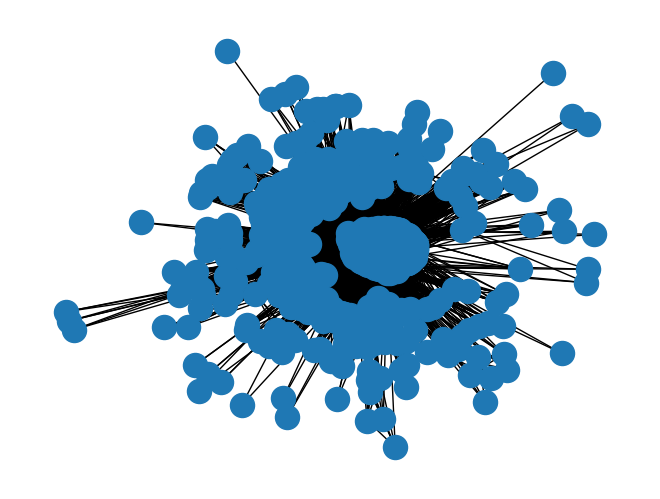

In [180]:
B = nx.bipartite.projected_graph(G, top_nodes)
nx.draw(B)

print(B)

B.nodes()

Graph with 409 nodes and 25631 edges


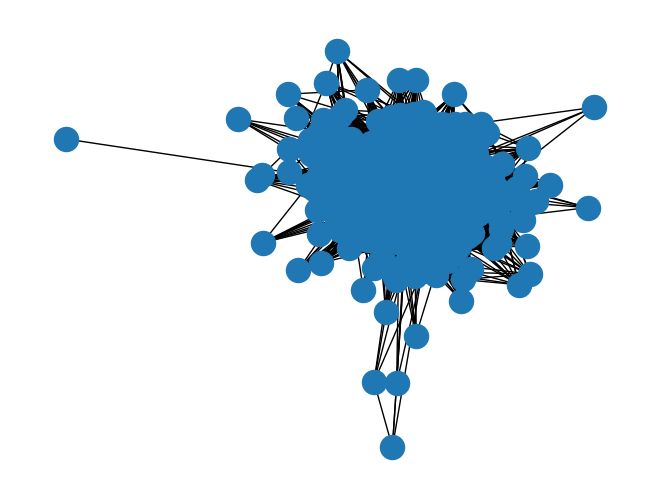

In [182]:
B = nx.bipartite.projected_graph(G, bottom_nodes)
print(B)
nx.draw(B)